# 2018101042

In [1]:
!pip install gif

# Excercise 1

In the tutorial you saw how to compute LDA for a two class problem. In this excercise we will work on a multi-class problem. We will be working with the famous Iris dataset that has been deposited on the UCI machine learning repository
(https://archive.ics.uci.edu/ml/datasets/Iris).

The iris dataset contains measurements for 150 iris flowers from three different species.

The three classes in the Iris dataset:
1. Iris-setosa (n=50)
2. Iris-versicolor (n=50)
3. Iris-virginica (n=50)

The four features of the Iris dataset:
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

<img src="iris_petal_sepal.png">



In [2]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import pi
import gif

In [3]:
### Importing the dataset

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']
dataset = pd.read_csv(url, names=names)

dataset.tail()

sepal-length  sepal-width  petal-length  petal-width           Class
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

### Data preprocessing
Once dataset is loaded into a pandas data frame object, the first step is to divide dataset into features and corresponding labels and then divide the resultant dataset into training and test sets. The following code divides data into labels and feature set:

In [5]:
X = dataset.iloc[:, 0:4].values
y = dataset.iloc[:, 4].values

The above script assigns the first four columns of the dataset i.e. the feature set to X variable while the values in the fifth column (labels) are assigned to the y variable.

The following code divides data into training and test sets:

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Feature Scaling

We will now perform feature scaling as part of data preprocessing too. For this task, we will be using scikit learn `StandardScalar`.

In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Write your code below

Write you code below to LDA on the IRIS dataset and compute the overall accuracy of the classifier.

In [8]:
### WRITE YOUR CODE HERE ####

In [9]:
X_train.shape, X_test.shape

((120, 4), (30, 4))

In [10]:
import seaborn as sns; sns.set();

# Function to plot our input data for classification tasks. Source: utils
def plot_2D_input_datapoints(X_inp, y_inp):
    sns.set()
    print(X_inp.shape)
    X_inp = X_inp[:, :2]
    print(X_inp.shape)
    inp_data = np.hstack((X_inp, y_inp.reshape(-1, 1)))
    print(inp_data.shape)
    df = pd.DataFrame(data=inp_data, columns=["$X_0$", "$X_1$", "$y$"])
    print(df.shape)
    sns.scatterplot(data=df, x="$X_0$", y="$X_1$", hue="$y$", legend='full')
    plt.title('Input data')
    plt.legend(loc='lower right')

(120, 4)
(120, 2)
(120, 3)
(120, 3)


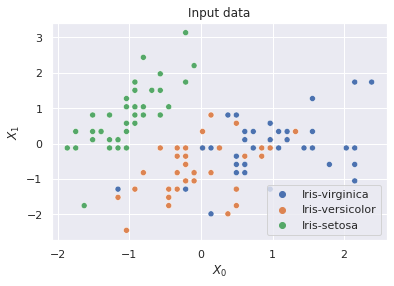

In [11]:
plot_2D_input_datapoints(X_train, y_train) # plotting only the first 2 parameters

In [12]:
# Sourced from https://github.com/eriklindernoren/ML-From-Scratch
# Method to normalize the data
def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [13]:
# Normalizing X_train and absorbing weight b of the hyperplane
X_normalized_train = normalize(X_train[:, :])

b_ones = np.ones((len(X_normalized_train), 1))
X_normalized_train = np.hstack((X_normalized_train, b_ones))

### Calculating covariance matrix

In [14]:
# Calculating covariance of an input matrix
def calc_cov_matrix(X_input):
    n_samples = np.shape(X_input)[0]
    cov_matrix = np.array((1 / (n_samples-1)) * (X_input - X_input.mean(axis=0)).T.dot(X_input - X_input.mean(axis=0)))

    return cov_matrix

#### PSEUDOCODE
Given a dataset $D = (x_i, y_i)_{i=1}^n$ and class labels $i = 0, 1, 2, ... m$.

1.  Collecting class-specific dataset. $D_i = \{x_j | y_j = c_i; j = 1, 2, ...., n\}$
2.  Calcualte class-specific means, $\mu_i = mean(D_i)$.
3.  Calculate between class scatter matrix,by taking the sum of the individual class scatter matrices
5.  Compute within class-specific by summing the within scatter for all classes
7.  Compute dominant eigenvector

In [15]:
def train(X_train, y_train):
    """Train method for LDA.
    Parameters
    -----------
    X_train: ndarray (num_examples(rows) vs num_features(columns))
     Input dataset which LDA will use to obtain optimal weights during training

    y_train: ndarray (num_examples(rows) vs class_labels(columns))
    """
    classes = np.unique(y_train)
    d = X_train.shape[1]
    # Caluclate the centre of all the points in the training set
    X_mean_all = X_train.mean(0)
    # initialing Sw and Sb (within class scatter) here
    Sw = np.zeros((d,d))
    Sb = np.zeros((d,d))
    mean_subtracted_class_means = np.zeros((len(classes),d))
    # For each class
    for i in range(len(classes)):
        # collect all sampels of that calasss
        x_class = X_train[np.argwhere(y_train == classes[i])[:, 0]]
        # Get number of sampels in the calss
        num_class = x_class.shape[0]
        # Computing class mean
        mean_class = x_class.mean(0)
        # Computing Sw (within class spread)
        Sw_class = calc_cov_matrix(x_class)
        #Sw += Sw_class*num_class
        Sw += Sw_class
        # Computing Sb (keeping means in a special place)
        mean_subtracted_class_means[i] = mean_class - X_mean_all
    # Computing Sb finally
    class_means_diff = mean_subtracted_class_means.sum(0)
    class_means_diff = class_means_diff.reshape((-1, 1))
    Sb = np.dot(class_means_diff,class_means_diff.T)
    
    # Calculating the target weights
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))

    # Getting the eigenvectors with the maximum eigenvalue.
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx][:2]
    weights = np.atleast_1d(eigvecs[:, idx])[:, :2]

    return weights.real

In [16]:
trained_weights = train(X_train, y_train)
X_train.shape, trained_weights.shape

((120, 4), (4, 2))

(120, 2)
(120, 2)
(120, 3)
(120, 3)


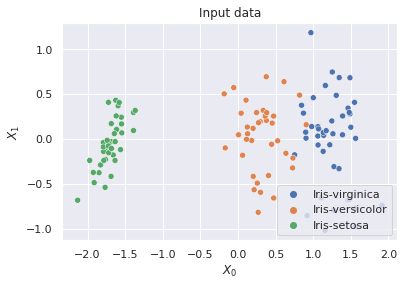

In [17]:
X_new_dim = np.dot(X_train,trained_weights)
plot_2D_input_datapoints(X_new_dim, y_train) # plotting only the first 2 parameters

(30, 2)
(30, 2)
(30, 3)
(30, 3)


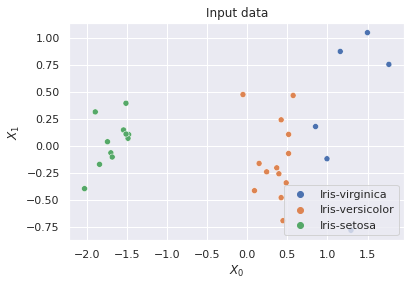

In [18]:
X_new_dim = np.dot(X_test,trained_weights)
plot_2D_input_datapoints(X_new_dim, y_test) # plotting only the first 2 parameters

# PREDICTION AND ACCURACY CHECKS

(150,) (150,)


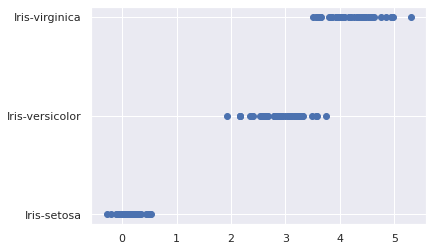

In [19]:
Y=np.dot(X,trained_weights.T[0])
print(Y.shape,y.shape)
plt.scatter(Y,y)

In [20]:
trained_weights

array([[-0.1676083 , -0.73463174],
       [-0.09882482,  0.05457614],
       [ 0.80853128, -0.02084573],
       [ 0.55535419,  0.67594609]])

# Using Gaussian model to predict classes

In [21]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB(priors = None)
X_new_dim = np.dot(X_train,trained_weights)
model.fit(X_new_dim,y_train)
print("Training set accuracy: ",model.score(X_new_dim,y_train))

model = GaussianNB(priors = None)
X_new_dim = np.dot(X_test,trained_weights)
model.fit(X_new_dim,y_test)
print("Test set accuracy: ", model.score(X_new_dim,y_test))


Training set accuracy:  0.975
Test set accuracy:  1.0


# Using the weights directly to predict the values
(refer the figure)

In [22]:
def predict(x):
  if(len(x)==4):
    x_pred = np.dot(x,trained_weights)
  else:
    x_pred = x
  if(x_pred[0]>=-1 and x_pred[0]<=0.8):
    if(k): return 0; 
    else: return 'Iris-versicolor'
  elif(x_pred[0]>0.8):                
    if(k): return 1; 
    else:   return 'Iris-virginica'
  else:                             
    if(k): return 2; 
    else:   return 'Iris-setosa'

In [23]:
count=0
k=0
for i in range(len(X_test)):
  if(predict(X_test[i])==y_test[i]):
    count+=1

print('Accuracy:',count/len(X_test))

Accuracy: 1.0


In [24]:
count=0
for i in range(len(X_train)):
  if(predict(X_train[i])==y_train[i]):
    count+=1

print('Accuracy:',count/len(X_train))

Accuracy: 0.975


# Plot
For a better plot, scroll down

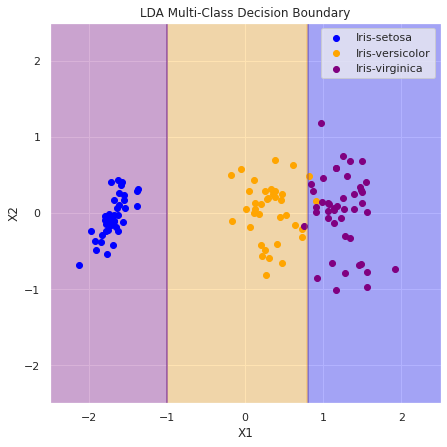

In [25]:
N = 500
k=1
X1 = np.linspace(-2.5, 2.5, N)
X2 = np.linspace(-2.5, 2.5, N)
X1, X2 = np.meshgrid(X1,X2)
Z = np.array([predict([x1,x2]) for x1,x2 in zip(X1.flatten(), X2.flatten())]).reshape((N,N))

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot()

classes = np.unique(y_train)
cs = ('blue','orange','purple')
ax.contour( X1, X2, Z, 2, alpha = .3, colors = ('orange','blue','purple'))
ax.contourf( X1, X2, Z, 2, alpha = .3, colors = ('orange','blue','purple'))
for i in range(len(classes)):
    # collect all sampels of that calasss
    x_class = X_train[np.argwhere(y_train == classes[i])[:, 0]]
    x_class_gud=x_class.dot(trained_weights)
    ax.scatter(x_class_gud.T[0],x_class_gud.T[1], color=cs[i], label=classes[i])

ax.set_xlabel('X1')
ax.set_ylabel('X2')

ax.set_title('LDA Multi-Class Decision Boundary')
plt.legend()
plt.show()



Apart from the small overlapping observed, LDA does perform the job pretty well.

# Attempting to find a better way rather than guessing from figure
1. Given the transformed matrix, identify the different variables in it: for example, the mean, the prior probability and standard deivation of each class under consideration.
2. Score each point as in, how much score it would get if it were of each class
3. Choose the most favourable class

(doing it all in 1D because dunno how to make it to 2D)

In [26]:
def predict(X_train,y,X_test):
  scores = np.zeros((classes.shape[0],X_test.shape[0]))
  for i in range(len(classes)):
    # collect all sampels of that calasss
    x_class = X_train[np.argwhere(y_train == classes[i])[:, 0]]
    # Get number of sampels in the calss
    num_class = x_class.shape[0]
    # Computing class mean
    mean_class = x_class.mean(0)
    # Computing the standard deviation
    std_class = x_class.std()
    # computing the probability for X_test to belong here
    prob = 1 / std_class * np.exp(-1 / 2 * (((X_test - mean_class) / std_class) ** 2))
    scores[i]=prob.copy()
  return classes[np.argmax(scores, axis=0)]

In [27]:
def accuracy(X_in,y_in):
  X_tt = X_in.dot(trained_weights.T[0])
  X_tn = X_train.dot(trained_weights.T[0])
  y_pred = predict(X_tn,y_in,X_tt)
  return np.sum(y_pred==y_in)/len(y_in)


In [28]:
print("Training accuracy:", accuracy(X_train, y_train))
print("Test accuracy:", accuracy(X_test, y_test))

Training accuracy: 0.975
Test accuracy: 1.0


(250000, 2) (250000,) (250000,)


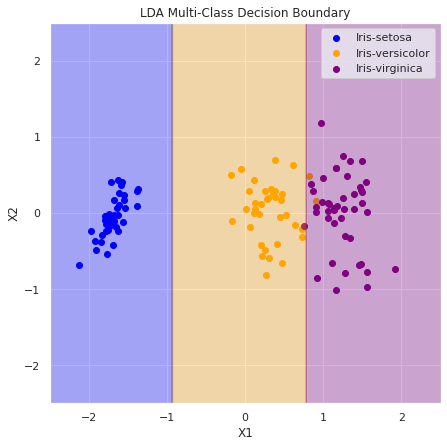

In [29]:
N = 500
k=1
X_tn = X_train.dot(trained_weights.T[0])
X1 = np.linspace(-2.5, 2.5, N)
X2 = np.linspace(-2.5, 2.5, N)
X1, X2 = np.meshgrid(X1,X2)
X11=X1.flatten()
X22=X2.flatten()
zzz = np.vstack((X11,X22)).T
print(zzz.shape,X11.shape,X22.shape)
Z = np.array(predict(X_tn,y,X11)).reshape((N,N))

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot()

classes = np.unique(y_train)
cs = ('blue','orange','purple')

for i in range(len(classes)):
    # collect all sampels of that calasss
    x_class = X_train[np.argwhere(y_train == classes[i])[:, 0]]
    x_class_gud=x_class.dot(trained_weights)
    ax.scatter(x_class_gud.T[0],x_class_gud.T[1], color=cs[i], label=classes[i])
    Z[Z==classes[i]]=i

ax.contour( X1, X2, Z, 2, alpha = .3, colors = ('blue','orange','purple'))
ax.contourf( X1, X2, Z, 2, alpha = .3, colors = ('blue','orange','purple'))

ax.set_xlabel('X1')
ax.set_ylabel('X2')

ax.set_title('LDA Multi-Class Decision Boundary')
plt.legend()
plt.show()

